In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

/home/john/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
###### NOTE ########
# SOME OF THE CODE FROM THIS NOTEBOOK WAS ADAPTED FROM AN EXAMPLE FROM 
# https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
# However it has been heavily modified


#img_width, img_height = 224, 224
img_dir = "assets/car-rocket-ship/images/"
train_data_dir = img_dir + "train"
validation_data_dir = img_dir + "val"
img_width, img_height = 128, 128
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
save_dir = "assets/imnet_nofc/VGG19/%ix%i/" % (img_width, img_height)


In [14]:
batch_size = 600

train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0,
width_shift_range = 0,
height_shift_range=0,
rotation_range=0)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0,
width_shift_range = 0,
height_shift_range=0,
rotation_range=0)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
shuffle=False,
class_mode = "categorical"
)

test_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
shuffle=False,
class_mode = "categorical")

Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [15]:
# takes a bit to load images
Dat_train = train_generator.next()
Dat_test = test_generator.next()

In [16]:
print(Dat_train[0].shape)
print(Dat_test[0].shape)

(600, 128, 128, 3)
(600, 128, 128, 3)


[0. 1. 0.]
[0. 1. 0.]


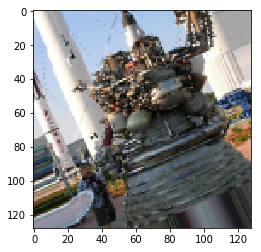

In [17]:
num = 300
plt.imshow(Dat_train[0][num,:,:,:])
print(Dat_train[1][num,:])
plt.imshow(Dat_test[0][num,:,:,:])
print(Dat_test[1][num,:])

In [18]:
# this takes a bit, it runs the network on all of the input images
X_tr = model.predict(Dat_train[0],verbose=1)
X_te = model.predict(Dat_test[0],verbose=1)


600/600 [==============================] - 36s 60ms/step


In [26]:
np.save(save_dir + "X_train",X_tr)
np.save(save_dir + "y_train",Dat_train[1])
np.save(save_dir + "X_test",X_te)
np.save(save_dir + "y_test",Dat_test[1])


In [18]:
print(xtr.shape)

(600, 7, 7, 512)


In [40]:
#JANK TRANIING STUFFF

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers import Dense, Activation
from keras import regularizers
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import numpy as np

import keras

load_dir = "assets/car-rocket-ship/imnet_nofc/VGG19/128x128/"
model_dir = "assets/models/"
X_train = np.load(load_dir + 'X_train.npy')
y_train = np.load(load_dir + 'y_train.npy')
X_test = np.load(load_dir + 'X_test.npy')
y_test = np.load(load_dir + 'y_test.npy')
N_tr = X_train.shape[0]
N_te = X_test.shape[0]
X_train = X_train.reshape(N_tr,-1)
X_test = X_test.reshape(N_te,-1)
in_size = X_train.shape[1]
#choosing bewtween different network architectures  
reg=0.001


def weights_grad(X,model):
	N = X.shape[0]
	M = model.output.shape[1]
	w = model.trainable_weights
	out = model.layers[-2].output 
	grads = []
	for i in range(N): #iterate over the batch
		for j in range(M): #iterate over class score
			grads.append(k.gradients(out[i,j],w))
	sess = tf.InteractiveSession()
	sess.run(tf.global_variables_initializer())
	grads_evaled = sess.run(grads,feed_dict={model.input:X})
	# grads_evaled is is an M*N list of the gradients of the weights.
	# each element of this list in another list, that will be something like
	# [W1_grad, b1_grad, W2_grad, b2_grad ...]
	return grads_evaled

# Train the model and plot training info
acc_  = []
vacc_ = []
loss_ = []
for i in range(10):
    model = Sequential([
        Dense(50,input_shape=(in_size,),kernel_regularizer=regularizers.l1(reg)),
        Activation('relu'),
        #Dropout(0.3),
        Dense(10,kernel_regularizer=regularizers.l1(reg)),
        Activation('relu'),
        #Dropout(0.3),
        Dense(3,kernel_regularizer=regularizers.l1(reg)),
        #Activation('softmax')
        ])

    model.compile(loss = "categorical_hinge", optimizer = optimizers.SGD(lr=0.003, momentum=0.9), metrics=["accuracy"])


    class LossHistory(ke.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []    
        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
    loss_history = LossHistory()                   
    hist = model.fit(X_train,y_train,
        validation_data=(X_test,y_test),
        batch_size = 100,
        epochs=25,
        verbose=2,
        callbacks=[loss_history]
        )
    acc_.append(hist.history['acc'])
    vacc_.append(hist.history['val_acc'])
    loss_.append(loss_history.losses)

    # Train the model and plot training info
acc2_  = []
vacc2_ = []
loss2_ = []
for i in range(10):
    model = Sequential([
        Dense(50,input_shape=(in_size,),kernel_regularizer=regularizers.l1(reg)),
        Activation('relu'),
        #Dropout(0.3),
        Dense(10,kernel_regularizer=regularizers.l1(reg)),
        Activation('relu'),
        #Dropout(0.3),
        Dense(3,kernel_regularizer=regularizers.l1(reg)),
        Activation('softmax')
        ])

    model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.003, momentum=0.9), metrics=["accuracy"])


    class LossHistory(ke.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []    
        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
    loss_history = LossHistory()                   
    hist = model.fit(X_train,y_train,
        validation_data=(X_test,y_test),
        batch_size = 100,
        epochs=25,
        verbose=2,
        callbacks=[loss_history]
        )
    acc2_.append(hist.history['acc'])
    vacc2_.append(hist.history['val_acc'])
    loss2_.append(loss_history.losses)



Train on 600 samples, validate on 600 samples
Epoch 1/25
 - 2s - loss: 6.7134 - acc: 0.3333 - val_loss: 6.5946 - val_acc: 0.3367
Epoch 2/25
 - 1s - loss: 6.5769 - acc: 0.3350 - val_loss: 6.5490 - val_acc: 0.3333
Epoch 3/25
 - 1s - loss: 6.5268 - acc: 0.3133 - val_loss: 6.4919 - val_acc: 0.3333
Epoch 4/25
 - 1s - loss: 6.4660 - acc: 0.3167 - val_loss: 6.4292 - val_acc: 0.3333
Epoch 5/25
 - 0s - loss: 6.4007 - acc: 0.3183 - val_loss: 6.3612 - val_acc: 0.3333
Epoch 6/25
 - 1s - loss: 6.3319 - acc: 0.3050 - val_loss: 6.2905 - val_acc: 0.3333
Epoch 7/25
 - 0s - loss: 6.2618 - acc: 0.3117 - val_loss: 6.2206 - val_acc: 0.3333
Epoch 8/25
 - 0s - loss: 6.1910 - acc: 0.3600 - val_loss: 6.1501 - val_acc: 0.3333
Epoch 9/25
 - 0s - loss: 6.1210 - acc: 0.3417 - val_loss: 6.0803 - val_acc: 0.3333
Epoch 10/25
 - 1s - loss: 6.0513 - acc: 0.3500 - val_loss: 6.0110 - val_acc: 0.3333
Epoch 11/25
 - 0s - loss: 5.9821 - acc: 0.3383 - val_loss: 5.9415 - val_acc: 0.3333
Epoch 12/25
 - 1s - loss: 5.9126 - acc:

Epoch 22/25
 - 0s - loss: 4.5870 - acc: 0.8950 - val_loss: 4.8719 - val_acc: 0.7533
Epoch 23/25
 - 0s - loss: 4.5104 - acc: 0.9017 - val_loss: 4.6536 - val_acc: 0.8167
Epoch 24/25
 - 1s - loss: 4.4195 - acc: 0.9083 - val_loss: 4.6218 - val_acc: 0.7983
Epoch 25/25
 - 0s - loss: 4.3103 - acc: 0.9250 - val_loss: 4.5197 - val_acc: 0.8233
Train on 600 samples, validate on 600 samples
Epoch 1/25
 - 2s - loss: 6.8314 - acc: 0.3267 - val_loss: 6.5921 - val_acc: 0.3333
Epoch 2/25
 - 1s - loss: 6.5747 - acc: 0.3550 - val_loss: 6.5496 - val_acc: 0.3333
Epoch 3/25
 - 0s - loss: 6.5260 - acc: 0.3483 - val_loss: 6.4938 - val_acc: 0.3333
Epoch 4/25
 - 1s - loss: 6.4668 - acc: 0.3300 - val_loss: 6.4305 - val_acc: 0.3333
Epoch 5/25
 - 0s - loss: 6.4017 - acc: 0.3333 - val_loss: 6.3628 - val_acc: 0.3333
Epoch 6/25
 - 0s - loss: 6.3333 - acc: 0.3350 - val_loss: 6.2941 - val_acc: 0.3333
Epoch 7/25
 - 0s - loss: 6.2637 - acc: 0.3383 - val_loss: 6.2230 - val_acc: 0.3333
Epoch 8/25
 - 0s - loss: 6.1934 - acc

Epoch 18/25
 - 0s - loss: 4.7336 - acc: 0.9267 - val_loss: 4.7910 - val_acc: 0.8917
Epoch 19/25
 - 0s - loss: 4.6808 - acc: 0.9250 - val_loss: 4.7403 - val_acc: 0.8817
Epoch 20/25
 - 1s - loss: 4.6826 - acc: 0.8867 - val_loss: 4.7909 - val_acc: 0.8150
Epoch 21/25
 - 0s - loss: 4.5520 - acc: 0.9200 - val_loss: 4.6007 - val_acc: 0.8883
Epoch 22/25
 - 0s - loss: 4.4568 - acc: 0.9317 - val_loss: 4.5233 - val_acc: 0.8900
Epoch 23/25
 - 0s - loss: 4.3965 - acc: 0.9350 - val_loss: 4.5014 - val_acc: 0.8683
Epoch 24/25
 - 0s - loss: 4.3589 - acc: 0.9233 - val_loss: 4.4978 - val_acc: 0.8267
Epoch 25/25
 - 0s - loss: 4.2513 - acc: 0.9383 - val_loss: 4.4286 - val_acc: 0.8317
Train on 600 samples, validate on 600 samples
Epoch 1/25
 - 2s - loss: 6.7040 - acc: 0.3717 - val_loss: 6.6452 - val_acc: 0.3850
Epoch 2/25
 - 1s - loss: 6.5841 - acc: 0.3883 - val_loss: 6.5550 - val_acc: 0.5467
Epoch 3/25
 - 1s - loss: 6.5296 - acc: 0.5017 - val_loss: 6.4972 - val_acc: 0.4367
Epoch 4/25
 - 1s - loss: 6.4673 -

Epoch 14/25
 - 0s - loss: 5.0332 - acc: 0.9250 - val_loss: 5.0927 - val_acc: 0.8733
Epoch 15/25
 - 1s - loss: 4.9660 - acc: 0.9283 - val_loss: 5.0224 - val_acc: 0.8717
Epoch 16/25
 - 1s - loss: 4.8800 - acc: 0.9217 - val_loss: 4.9490 - val_acc: 0.8933
Epoch 17/25
 - 0s - loss: 4.7962 - acc: 0.9417 - val_loss: 4.8782 - val_acc: 0.8933
Epoch 18/25
 - 1s - loss: 4.7044 - acc: 0.9550 - val_loss: 4.8093 - val_acc: 0.8900
Epoch 19/25
 - 0s - loss: 4.6349 - acc: 0.9517 - val_loss: 4.7699 - val_acc: 0.8783
Epoch 20/25
 - 0s - loss: 4.5823 - acc: 0.9433 - val_loss: 4.6971 - val_acc: 0.8833
Epoch 21/25
 - 0s - loss: 4.5040 - acc: 0.9600 - val_loss: 4.6673 - val_acc: 0.8583
Epoch 22/25
 - 0s - loss: 4.4641 - acc: 0.9450 - val_loss: 4.6353 - val_acc: 0.8417
Epoch 23/25
 - 0s - loss: 4.3832 - acc: 0.9517 - val_loss: 4.5858 - val_acc: 0.8483
Epoch 24/25
 - 0s - loss: 4.3009 - acc: 0.9567 - val_loss: 4.4386 - val_acc: 0.8883
Epoch 25/25
 - 0s - loss: 4.2187 - acc: 0.9750 - val_loss: 4.3754 - val_acc:

Epoch 10/25
 - 0s - loss: 5.8951 - acc: 0.6217 - val_loss: 5.8611 - val_acc: 0.6250
Epoch 11/25
 - 0s - loss: 5.8106 - acc: 0.6300 - val_loss: 5.7676 - val_acc: 0.6467
Epoch 12/25
 - 1s - loss: 5.7273 - acc: 0.6383 - val_loss: 5.6901 - val_acc: 0.6200
Epoch 13/25
 - 0s - loss: 5.6468 - acc: 0.6533 - val_loss: 5.6395 - val_acc: 0.6333
Epoch 14/25
 - 0s - loss: 5.5704 - acc: 0.6383 - val_loss: 5.5436 - val_acc: 0.6267
Epoch 15/25
 - 0s - loss: 5.4913 - acc: 0.6450 - val_loss: 5.4650 - val_acc: 0.6350
Epoch 16/25
 - 0s - loss: 5.4078 - acc: 0.6433 - val_loss: 5.3833 - val_acc: 0.6400
Epoch 17/25
 - 0s - loss: 5.3337 - acc: 0.6517 - val_loss: 5.3100 - val_acc: 0.6467
Epoch 18/25
 - 1s - loss: 5.2602 - acc: 0.6517 - val_loss: 5.2444 - val_acc: 0.6433
Epoch 19/25
 - 0s - loss: 5.1832 - acc: 0.6500 - val_loss: 5.1698 - val_acc: 0.6450
Epoch 20/25
 - 0s - loss: 5.1125 - acc: 0.6550 - val_loss: 5.0924 - val_acc: 0.6450
Epoch 21/25
 - 0s - loss: 5.0372 - acc: 0.6567 - val_loss: 5.0228 - val_acc:

Epoch 6/25
 - 1s - loss: 5.7318 - acc: 0.8550 - val_loss: 5.6998 - val_acc: 0.8600
Epoch 7/25
 - 1s - loss: 5.6181 - acc: 0.8633 - val_loss: 5.6876 - val_acc: 0.8333
Epoch 8/25
 - 0s - loss: 5.5296 - acc: 0.8750 - val_loss: 5.5340 - val_acc: 0.8633
Epoch 9/25
 - 1s - loss: 5.4533 - acc: 0.8883 - val_loss: 5.6054 - val_acc: 0.8083
Epoch 10/25
 - 0s - loss: 5.4115 - acc: 0.8717 - val_loss: 5.5511 - val_acc: 0.7800
Epoch 11/25
 - 0s - loss: 5.3253 - acc: 0.8800 - val_loss: 5.4870 - val_acc: 0.7867
Epoch 12/25
 - 0s - loss: 5.2544 - acc: 0.8817 - val_loss: 5.2597 - val_acc: 0.8483
Epoch 13/25
 - 0s - loss: 5.1065 - acc: 0.9283 - val_loss: 5.1468 - val_acc: 0.8733
Epoch 14/25
 - 1s - loss: 5.0256 - acc: 0.9250 - val_loss: 5.0917 - val_acc: 0.8833
Epoch 15/25
 - 0s - loss: 4.9400 - acc: 0.9283 - val_loss: 5.0813 - val_acc: 0.8517
Epoch 16/25
 - 0s - loss: 4.8608 - acc: 0.9400 - val_loss: 5.0381 - val_acc: 0.8517
Epoch 17/25
 - 0s - loss: 4.8382 - acc: 0.9217 - val_loss: 4.8913 - val_acc: 0.8

/home/john/anaconda3/envs/cs231n/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


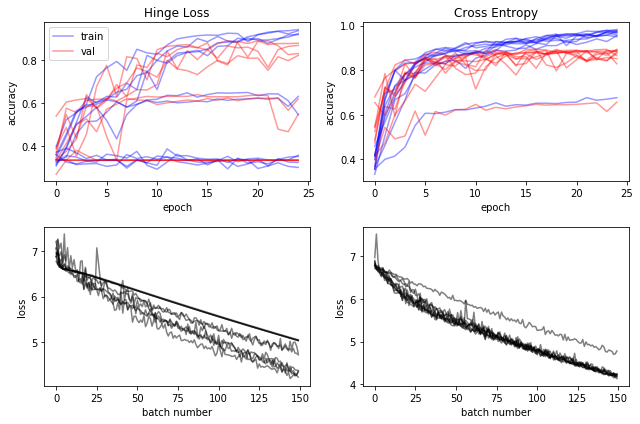

In [50]:
plt.figure(figsize=(9,6))
for i in range(len(vacc_)):
    plt.subplot(2,2,1)
    plt.plot(acc_[i],color='blue',alpha=0.4)
    plt.plot(vacc_[i],'red',alpha=0.4)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.subplot(2,2,3)
    plt.plot(loss_[i],'black', label="val",alpha=0.5)
    plt.xlabel("batch number")
    plt.ylabel("loss")
    plt.grid()
    plt.subplot(2,2,2)
    plt.plot(acc2_[i],color='blue',alpha=0.4)
    plt.plot(vacc2_[i],'red',alpha=0.4)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.subplot(2,2,4)
    plt.plot(loss2_[i],'black', label="val",alpha=0.5)
    plt.xlabel("batch number")
    plt.ylabel("loss")
    plt.grid()

plt.subplot(2,2,1)
plt.title("Hinge Loss")
plt.legend(['train','val'])

plt.subplot(2,2,2)
plt.title("Cross Entropy")

plt.tight_layout()
plt.savefig('im1.png')

In [ ]:
model = keras.load_model("")
model.
